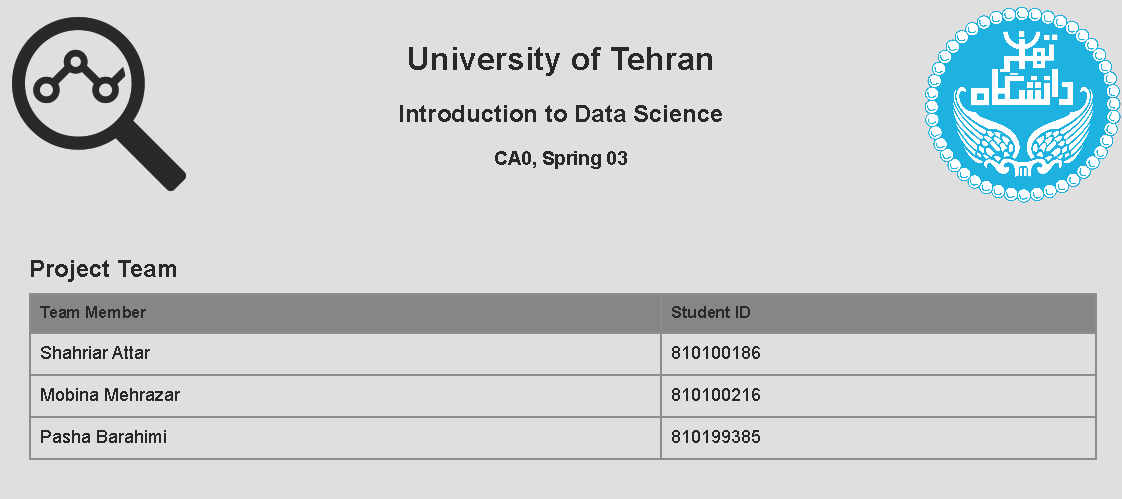


# Web Scraping and Introductory Data Analysis

## Table of Contents

-   [Web Scraping and Introductory Data Analysis](#web-scraping-and-introductory-data-analysis)
    -   [Introduction](#introduction)
    -   [Objectives](#objectives)
    -   [Tasks](#tasks)
    -   [Environment Setup](#environment-setup)
    -   [Data Collection](<#Data-Collection-(Etherscan)>)
    -   [Data Analysis](#Data-Analysis)
    -   [Data Sampling](#Data-Sampling-and-Analysis)
    -   [Questions](#Questions)
    -   [Resources](#Resources)

## Introduction

In this assignment, we will delve into web scraping and perform an introductory data analysis. This assignment will be a hands-on exercise that will help us become familiar with the process of extracting data from websites and conducting basic statistical analysis.

## Objectives

The purpose of this assignment is as follows:

1. Setting up a Python environment with the necessary libraries for web scraping and data analysis.
2. Writing a web scraping script using `Beautiful Soup` and `Selenium` to collect data from a website.
3. Sampling from the collected dataset and compare the statistics of the sample and the population.

## Tasks

1. **Environment Setup**: Installing the required libraries such as `Beautiful Soup`, `Selenium`, `pandas`, `numpy`, `matplotlib`, and `seaborn`.

2. **Web Scraping**: Writing a script to scrape transaction data from [Etherscan.io](https://etherscan.io/txs). we should use `Selenium` to interact with the website and `Beautiful Soup` to parse the HTML content.

3. **Data Sampling**: Once the data is collected, we will create a sample from the dataset. Then, we well compare the sample statistics (mean and standard deviation) with the population statistics.


## Environment Setup

We'll begin by setting up your Python environment and installing the necessary libraries.


In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import csv
import re

In [5]:
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager

# ** Chrome
# driver = webdriver.Chrome(ChromeDriverManager().install()) # If you don't have the chromedriver installed, it will install it for you
# driver = webdriver.Chrome() # If you have the chromedriver installed, you can use this line


# ** Firefox
# driver = webdriver.Firefox(GeckoDriverManager().install()) # If you don't have the geckodriver installed, it will install it for you
driver = webdriver.Firefox() # If you have the geckodriver installed, you can use this line

In [4]:
SCRAPE_URL = "https://etherscan.io/txs"
SCRAPE_BLOCKS = 10
TRANSACTIONS_CSV = "../data/transactions.csv"
TRANSACTIONS_CLEANED_CSV = "../data/transactions_cleaned.csv"
SAMPLE_PROPORTION = 0.1
RANDOM_SEED = 42

## Data Collection (Etherscan)

In this section, we will use web scraping to gather transaction data from the Ethereum blockchain using the Etherscan block explorer. Our objective is to collect transactions from the **last 10 blocks** on Ethereum.

To accomplish this task, we will employ web scraping techniques to extract the transaction data from the Etherscan website. The URL we will be targeting for our data collection is:

[https://etherscan.io/txs](https://etherscan.io/txs)

### Considerations

-   **Rate Limiting**: The website might have implemented a rate limiting system. In order to avoid being blocked, we can use `time.sleep()` to add delays between requests.

-   **Dynamic Content**: The Etherscan website may load content dynamically. However, the way we use `Selenium` to interact with the website results in the content being fully loaded before we scrape it.

-   **Data Cleaning**: After extraction, we should clean the data to remove any inconsistencies or errors that may have occurred during the scraping process.


### Steps

1. **Navigating to the URL**: We'll use Selenium to open the Etherscan transactions page in a browser.


In [6]:
driver.get(SCRAPE_URL)

2. **Locating the Transaction Data**: Let's iIdentify the HTML elements that contain the transaction data for the specified block range.

    The transaction data is contained in a table with the `class` attributes `table`, `table-hover`, `table-align-middle`, and `mb-0`. We can use `Beautiful Soup` to parse the HTML content.

3. **Extracting the Data**: The below script is used to extract the transaction details e.g. Hash, Method, Block, etc.


In [4]:
def parse_transactions(page_source: str) -> list[dict[str, str]]:
    soup = BeautifulSoup(page_source, "html.parser")
    table = soup.find("table", {"class": "table table-hover table-align-middle mb-0"})
    body = table.find("tbody")
    rows = body.find_all("tr")
    transactions : list[dict[str, str]] = []
    for row in rows:
        cells = row.find_all("td")
        if len(cells) > 0:
            transaction = {
                "Txn Hash": cells[1].text.strip(),
                "Method": cells[2].text.strip(),
                "Block": cells[3].text.strip(),
                "Timestamp": cells[4].text.strip(),
                "Age": cells[5].text.strip(),
                "From": cells[7].text.strip(),
                "To": cells[9].text.strip(),
                "Value": cells[10].text.strip(),
                "Txn Fee": cells[11].text.strip(),
            }
            transactions.append(transaction)
    return transactions

4. **Handling Pagination**: As the transactions span multiple pages, we should implement pagination handling to navigate through the pages and collect all relevant transaction data. A problem that we encountered was that the website has a dynamic loading system, when we go to the next page, some new transactions were loaded so some entries were duplicated. We solved this later in data cleaning.


In [7]:
last_block = None
first_block = None
transactions : list[dict[str, str]] = []

while True:
    transactions += parse_transactions(driver.page_source)

    if first_block is None:
        last_block = int(transactions[0]["Block"])
        first_block = last_block - SCRAPE_BLOCKS + 1

    if int(transactions[-1]["Block"]) < first_block:
        break

    driver.find_element(By.LINK_TEXT, "Next").click()

driver.close()

In [17]:
print(f"Scraped {len(transactions)} transactions from blocks {first_block} to {last_block}")
print(transactions[0])
print(transactions[-1])

Scraped 4700 transactions from blocks 19334507 to 19334516
{'Txn Hash': '0x87ad207685a04a5630df4dc60f691b3e6679896f1def7d3c5a8af8600be9e1c0', 'Method': 'Sell To Uniswap', 'Block': '19334516', 'Timestamp': '2024-02-29 16:59:47', 'Age': '11 secs ago', 'From': '0xD11c274E...100D7A541', 'To': '0x: Exchange Proxy', 'Value': '0.581130968 ETH', 'Txn Fee': '0.00967144'}
{'Txn Hash': '0xd57fcd1d504476c3d9daad2f5cacb5fb142aba92c9b71a1c54cdcc6f2f14e6f0', 'Method': 'Transfer', 'Block': '19334506', 'Timestamp': '2024-02-29 16:57:47', 'Age': '5 mins ago', 'From': '0x3E56a0C8...15B4f89D0', 'To': 'Tether: USDT Stablecoin', 'Value': '0 ETH', 'Txn Fee': '0.00316241'}


5. **Storing the Data**: We'll save the scraped data in CSV format for further analysis.


In [10]:
with open(TRANSACTIONS_CSV, "w", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=transactions[0].keys(), lineterminator='\n')
    writer.writeheader()
    writer.writerows(transactions)

## Data Analysis

Now that we have collected the transaction data from Etherscan, the next step is to perform conduct an initial analysis. This task will involve the following steps:

1. **Loading the Data**: First, we'll import the collected transaction data from the CSV file into a pandas DataFrame.


In [28]:
df = pd.read_csv(TRANSACTIONS_CSV)
df.head()

,Txn Hash,Method,Block,Timestamp,Age,From,To,Value,Txn Fee
0,0x87ad207685a04a5630df4dc60f691b3e6679896f1def...,Sell To Uniswap,19334516,2024-02-29 16:59:47,11 secs ago,0xD11c274E...100D7A541,0x: Exchange Proxy,0.581130968 ETH,0.009671
1,0x3fb7613717d61a3f6bf330c542e061463aa1868aa24a...,Transfer,19334516,2024-02-29 16:59:47,11 secs ago,0x9c95822B...53D8C79a3,VAIOT: VAI Token,0 ETH,0.002132
2,0x341367774a838fee5d7c7465b9eb151ddbe012dce6de...,Sell To Uniswap,19334516,2024-02-29 16:59:47,11 secs ago,0x3b454995...7500236a3,0x: Exchange Proxy,0.016822346 ETH,0.008656
3,0x9317998e91e7ad56cf0bab4927a425a56ec493243c03...,Transfer,19334516,2024-02-29 16:59:47,11 secs ago,0x37A653a8...8B8b0CFCC,0x57A54b0A...94f9DD578,0.003698047 ETH,0.001506
4,0x87c23770735932244ced56868f2387123505922c42b4...,Execute,19334516,2024-02-29 16:59:47,11 secs ago,0x73491B6d...1CdD889C9,Uniswap: Universal Router,0.08 ETH,0.011457


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Txn Hash   4700 non-null   object 
 1   Method     4700 non-null   object 
 2   Block      4700 non-null   int64  
 3   Timestamp  4700 non-null   object 
 4   Age        4700 non-null   object 
 5   From       4700 non-null   object 
 6   To         4700 non-null   object 
 7   Value      4700 non-null   object 
 8   Txn Fee    4700 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 330.6+ KB


As we can see, we have 4700 rows and 9 columns in our dataset. The dataset contains duplicate entries, which we will remove in the next step.


2. **Data Cleaning**: Clean the data by converting data types, removing any irrelevant information, and handling **duplicate** values.


First, we will calculate the first and last block numbers as we may use the CSV instead of scraping the website again.


In [30]:
last_block = int(df["Block"].iloc[0])
first_block = last_block - SCRAPE_BLOCKS + 1

df = df[df["Block"].between(first_block, last_block)]

Then, we'll remove duplicate transactions as we may have scraped the same transaction multiple times due to pagination


In [31]:
df = df.drop_duplicates(subset=["Txn Hash"], keep="first", ignore_index=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Txn Hash   1883 non-null   object 
 1   Method     1883 non-null   object 
 2   Block      1883 non-null   int64  
 3   Timestamp  1883 non-null   object 
 4   Age        1883 non-null   object 
 5   From       1883 non-null   object 
 6   To         1883 non-null   object 
 7   Value      1883 non-null   object 
 8   Txn Fee    1883 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 132.5+ KB


As we can see, after removing the duplicates and the transactions that are not in the last 10 blocks, we will have 1883 rows.


In [33]:
df[~df["Value"].str.contains("ETH")]

,Txn Hash,Method,Block,Timestamp,Age,From,To,Value,Txn Fee
834,0x7bd7632e58f8c5abbad7cc8f5138b5e17da30370fc9f...,0x020965d0,19334512,2024-02-29 16:58:59,2 mins ago,0xD267fdA7...284b72dA9,Seawise: Resolver,77 wei,0.027082


Some values are in wei, kwei, mwei, gwei, etc. We need to convert them to `ETH`.

The conversion rates are as follows:

| Unit   | ETH Value  |
| ------ | ---------- |
| Wei    | $10^{-18}$ |
| Kwei   | $10^{-15}$ |
| Mwei   | $10^{-12}$ |
| Gwei   | $10^{-9}$  |
| Szabo  | $10^{-6}$  |
| Finney | $10^{-3}$  |
| Ether  | $1$        |


In [34]:
def convert_values_to_eth(df: pd.DataFrame, unit: str, decimals: int):
    pattern = f" {unit}\\b"
    df.loc[df["Value"].str.contains(pattern), "Value"] = df[df["Value"].str.contains(pattern)].apply(
        lambda x: str(int(re.sub(pattern, "", x["Value"])) / 10**decimals) + " ETH",
        axis=1,
    )

# the value of 1 ETH in different units (the number is the power of 10)
crypto_units = {"wei": 18, "kwei": 15, "mwei": 12, "gwei": 9, "szabo": 6, "finney": 3, "ether": 0}

for unit, decimals in crypto_units.items():
    convert_values_to_eth(df, unit, decimals)

The values have an 'ETH' suffix. We need to remove the 'ETH' suffix and convert the object dtype into `float64`.


In [35]:
def convert_values_to_float(value: str) -> float:
    return float(value.replace("ETH", ""))

df["Value"] = df["Value"].apply(convert_values_to_float)

In [36]:
any_missing_values = df.isnull().any().any()
print(f"Is there some missing values in this dataframe? {any_missing_values}")

Is there some missing values in this dataframe? False


Since we have `TimeStamp` column, we can convert it to a datetime object, and we can get rid of the `Age` column. Also some columns like `From` and `To` are not necessary for our analysis, so we can remove them. The `Txn Hash` column is the same as the index (unique for each transaction), so this column is not necessary as well and we can remove it.


In [37]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.drop(columns=["Age", "Txn Hash", "From", "To"])

Parsing `Method` Column:


In [38]:
df["Method"].value_counts().head(10)

Method
Transfer               1210
Execute                 118
Approve                 117
Swap                     21
Deposit ETH              21
Register Continu...      20
Transfer From            19
Withdraw                 18
Transfer*                16
Swap Exact Token...      15
Name: count, dtype: int64

In [39]:
df["Method"].value_counts().count()

149

The `Method` column contains 149 unique values. We will consider the first 10 categories and group the rest into an 'Other' category. We will then visualize the distribution of the `Method` column.


In [40]:
key_methods : list[str] = df["Method"].value_counts().head(10).index.tolist()
def categorize_method(method: str) -> str:
    for key_method in key_methods:
        if key_method.lower() == method.lower():
            return key_method
    return "Other"

df["Method"] = df["Method"].apply(categorize_method)

In [41]:
df["Method"].value_counts()

Method
Transfer               1210
Other                   307
Execute                 118
Approve                 117
Deposit ETH              22
Swap                     21
Register Continu...      20
Transfer From            19
Withdraw                 18
Transfer*                16
Swap Exact Token...      15
Name: count, dtype: int64

In the above result, we can see that the `Method` column now contains 11 unique values.


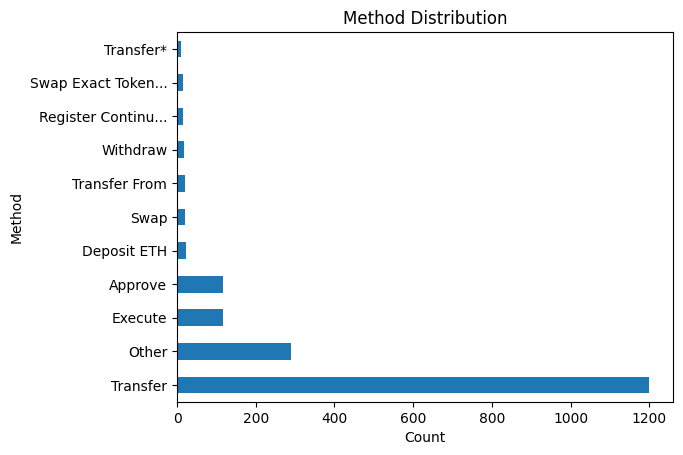

In [126]:
df['Method'].value_counts().plot.barh()
plt.xlabel('Count')
plt.ylabel('Method')
plt.title('Method Distribution')
plt.show()

Then, we'll remove outliers for `Value` and `Txn Fee` columns using the z-score method. We'll consider the transactions with z-score less than 3 as outliers.


In [42]:
z_scores_value = stats.zscore(df["Value"])
z_scores_txn_fee = stats.zscore(df["Txn Fee"])

threshold = 3

df = df[(np.abs(z_scores_value) < threshold) & (np.abs(z_scores_txn_fee) < threshold)]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1843 entries, 0 to 1882
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Method     1843 non-null   object        
 1   Block      1843 non-null   int64         
 2   Timestamp  1843 non-null   datetime64[ns]
 3   Value      1843 non-null   float64       
 4   Txn Fee    1843 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 86.4+ KB


In [44]:
df = df[["Block", "Timestamp", "Method", "Value", "Txn Fee"]] # swap columns for better understanding
df.to_csv(TRANSACTIONS_CLEANED_CSV, index=False)

In [45]:
df = pd.read_csv(TRANSACTIONS_CLEANED_CSV)

3. **Statistical Analysis**: We'll calculate the mean and standard deviation of the population. Evaluate these statistics to understand the distribution of transaction values. The analysis and plotting will be on **Txn Fee** and **Value**.


In [48]:
def print_stats(df: pd.DataFrame, column: str):
    mean = df[column].mean()
    std = df[column].std()
    min = df[column].min()
    max = df[column].max()
    range = max - min
    median = df[column].median()
    mode = df[column].mode().values[0]
    variance = df[column].var()
    skewness = df[column].skew()
    kurtosis = df[column].kurtosis()

    print(f"{column} stats:")
    print(f"Mean: {mean:.8f}")
    print(f"Standard deviation: {std:.8f}")
    print(f"Minimum: {min:.8f}")
    print(f"Maximum: {max:.8f}")
    print(f"Range: {range:.8f}")
    print(f"Median: {median:.8f}")
    print(f"Mode: {mode:.8f}")
    print(f"Variance: {variance:.8f}")
    print(f"Skewness: {skewness:.8f}")
    print(f"Kurtosis: {kurtosis:.8f}")
    print()

In [49]:
print_stats(df, "Value")
print_stats(df, "Txn Fee")

Value stats:
Mean: 0.24994040
Standard deviation: 0.89035233
Minimum: 0.00000000
Maximum: 10.80500000
Range: 10.80500000
Median: 0.00254000
Mode: 0.00000000
Variance: 0.79272728
Skewness: 6.71155145
Kurtosis: 55.22774745

Txn Fee stats:
Mean: 0.00528661
Standard deviation: 0.00562944
Minimum: 0.00130800
Maximum: 0.04070443
Range: 0.03939643
Median: 0.00323312
Mode: 0.00130820
Variance: 0.00003169
Skewness: 2.22899742
Kurtosis: 5.95670434



-   **Value**:

    -   The mean is much larger than the median, and the data is positively skewed. This suggests that there are a few very high transaction values that are pulling the mean upwards. These could be outliers.
    -   The high kurtosis value indicates that the distribution has heavy tails, which means there are a significant number of transactions with values that are extremely larger or smaller than the mean. This further supports the presence of outliers.
    -   The standard deviation is also quite large, indicating a wide spread of transaction values.

-   **Tnx Fee**:
    -   The mean and median are closer together compared to the transaction values, suggesting a more symmetrical distribution. However, the data is still positively skewed, indicating that there are some transactions with higher fees.
    -   The lower kurtosis value compared to the transaction values suggests fewer outliers in the transaction fees.
    -   The standard deviation is also smaller than that of the transaction values, indicating a narrower spread of transaction fees.


In [55]:
zero_value = df[df["Value"] == 0].shape[0]
print(f"Percentage of transactions with zero value: {zero_value / df.shape[0] * 100:.2f}%")

Percentage of transactions with zero value: 48.13%


As we can see, almost half of the transactions have a value of 0. This is likely due to the fact that many transactions on the Ethereum blockchain are not value transfers, but rather smart contract interactions.

As an example, in some exchanges such as `Coinbase`, when we transfer our assets to another wallet, a contract transaction with 0 value is created, which triggers some internal transactions which contain the actual value. This is why we have a lot of transactions with 0 value. Check [this link](https://ethereum.stackexchange.com/questions/154783/why-is-transaction-value-showing-0-eth-on-etherscan) for more information.

However, we will not remove these transactions as they are valid transactions and are part of the Ethereum blockchain and we need to consider them in our analysis.

We will visualize the distribution of transaction values to better understand this phenomenon.


4. **Visualization**: This phase involves the creation of visual representations to aid in the analysis of transaction values. The visualizations include:
    - A histogram for each data column, which provides a visual representation of the data distribution. The selection of bin size is crucial and should be based on the data's characteristics to ensure accurate representation. We'll provide an explanation on the bin size selection!


In [56]:
def plot_histogram(
    data: pd.Series,
    title: str,
    xlabel: str,
    ylabel: str,
    bins: int,
    color: str,
    xlim: tuple = (-0.5, 6),
    ylim: tuple = (0, 1800),
):
    plt.figure(figsize=(20, 10))
    plt.hist(data, bins=bins, color=color)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_histograms(
    df: pd.DataFrame,
    bins: int,
    color: str,
    subplot: bool = True,
    labels: list[str] = None,
    xlim: tuple = (-0.5, 6),
    ylim: tuple = (0, 1800),
):
    if subplot:
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].hist(df["Value"], bins=bins, color=color)
        ax[0].set_title("Value")
        ax[0].set_xlabel("Value")
        ax[0].set_ylabel("Frequency")
        ax[0].set_xlim(xlim)
        ax[0].set_ylim(ylim)
        ax[1].hist(df["Txn Fee"], bins=bins, color=color)
        ax[1].set_title("Txn Fee")
        ax[1].set_xlabel("Txn Fee")
        ax[1].set_ylabel("Frequency")
        ax[1].set_xlim(xlim)
        ax[1].set_ylim(ylim)
        if labels is not None:
            ax[0].set_xticklabels(labels)
            ax[1].set_xticklabels(labels)
        plt.show()
    else:
        plot_histogram(df["Value"], "Value", "Value", "Frequency", bins, color)
        plot_histogram(df["Txn Fee"], "Txn Fee", "Txn Fee", "Frequency", bins, color)

For choosing the bin size, we use four methods:

-   **Square-root choice**: The number of bins is the square root of the number of data points.
    $$\text{Number of Bins} = \sqrt{\text{Number of Data Points}}$$


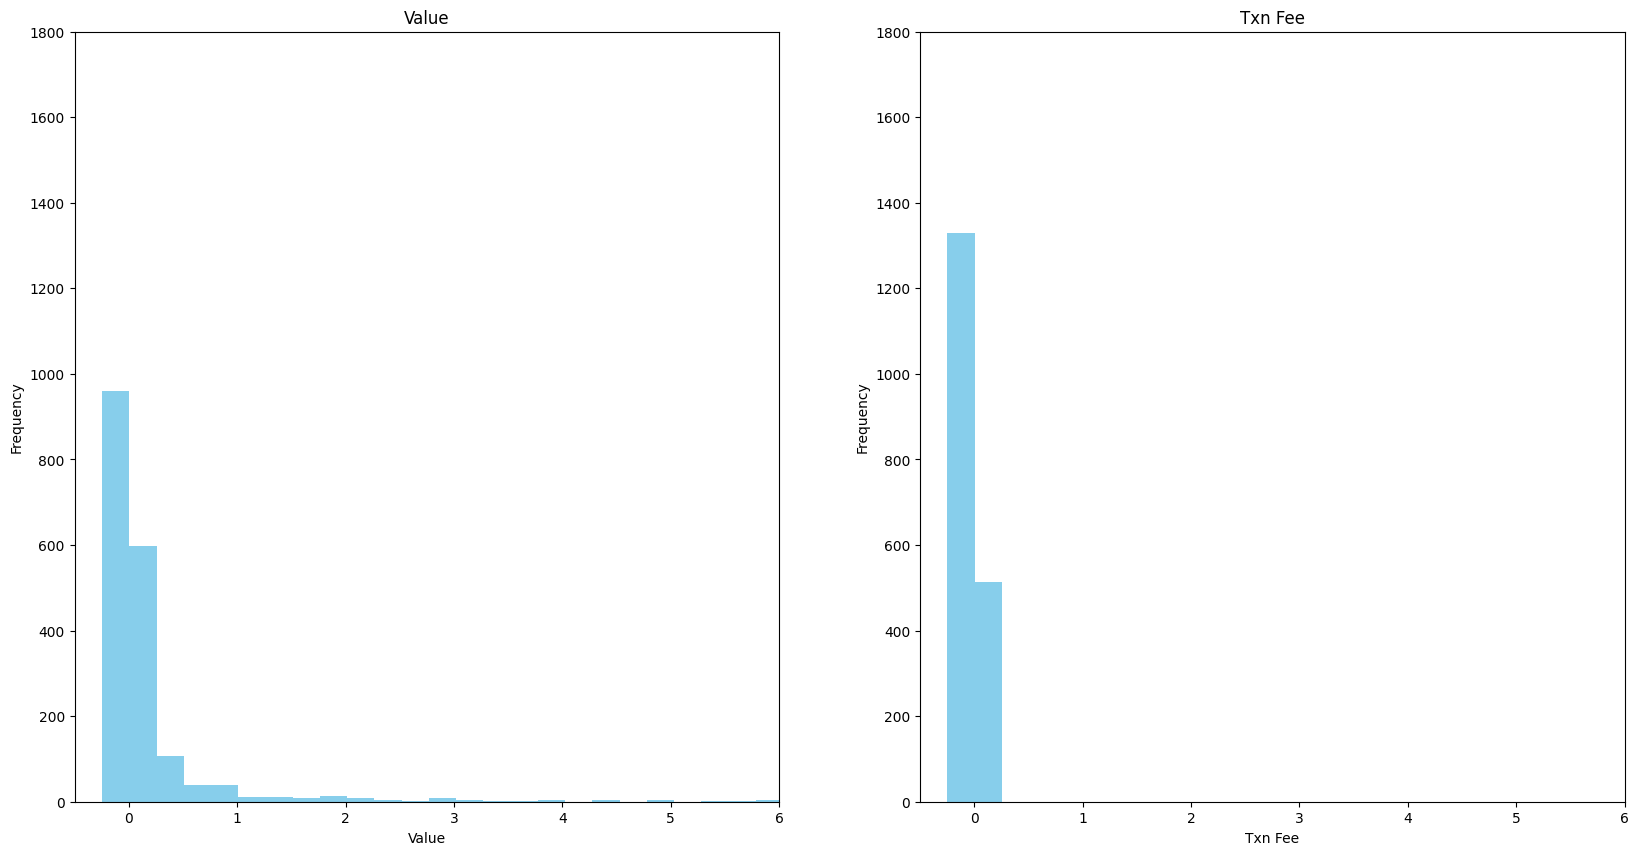

In [57]:
# In all of them the minus one is to avoid the right limit of the bin to be included in the bin
bins = np.histogram_bin_edges(df["Value"], bins="sqrt") - 1 # bins = int(np.sqrt(len(df)))
plot_histograms(df, bins, "skyblue")

This method is simple and easy to calculate and fairly robust to changes in the data.


-   **Sturges' formula**: The number of bins is calculated using the formula:
    $$\text{Number of Bins} = 1 + \log_2(N)$$
    where $N$ is the number of data points.


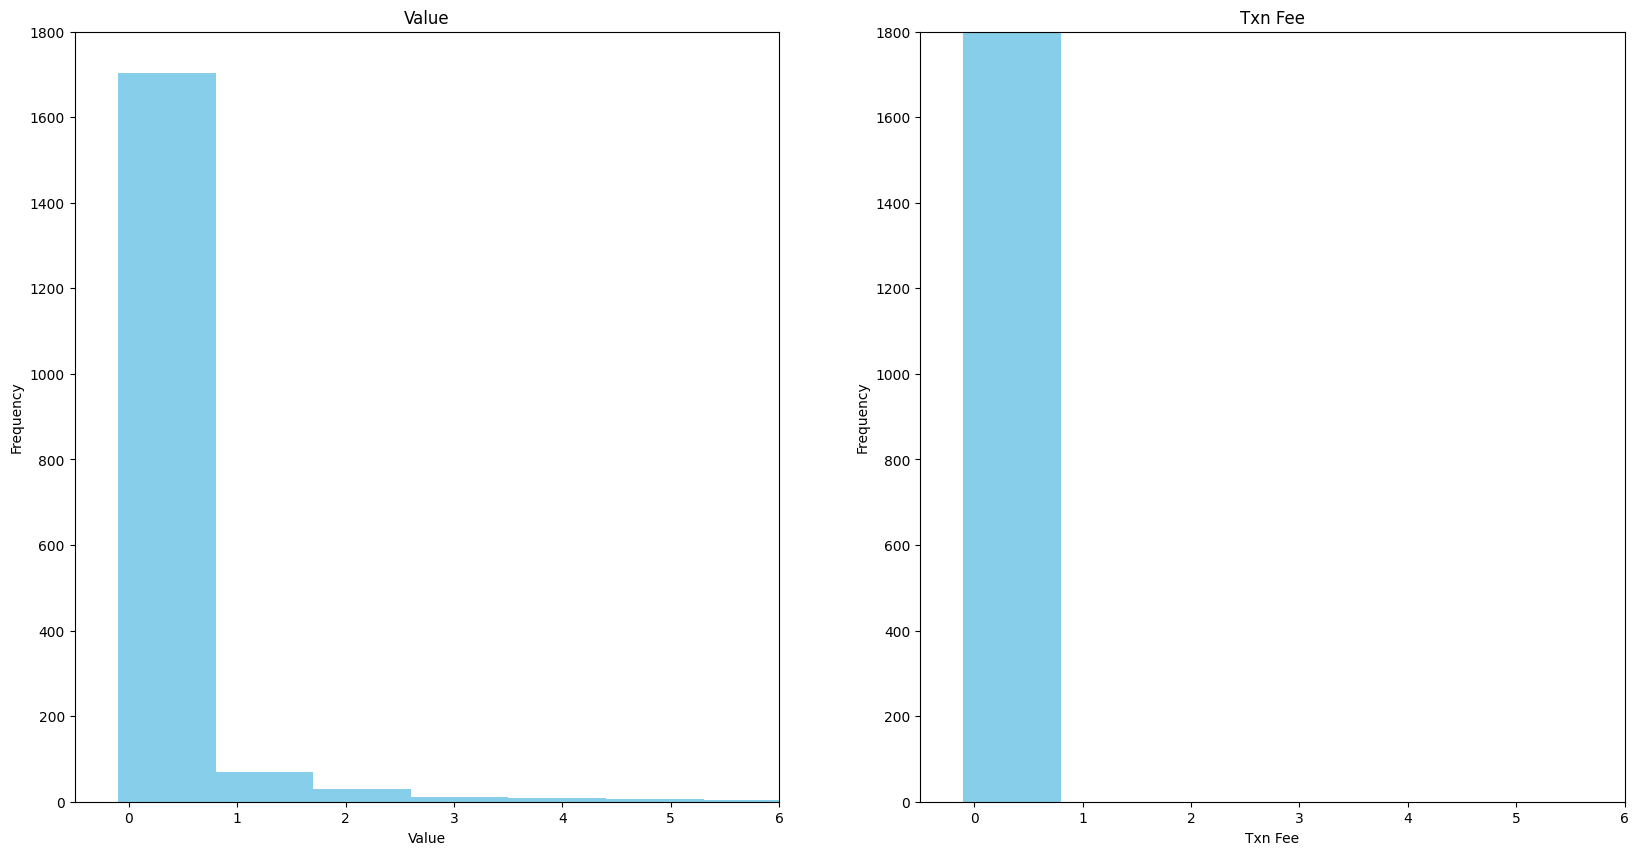

In [58]:
bins = np.histogram_bin_edges(df["Value"], bins="sturges") - 1 # bins = int(np.ceil(1 + np.log2(len(df))))
plot_histograms(df, bins, "skyblue")

In this method the number of bins increases logarithmically with the number of data points. It is simple to calculate and is a good choice for small datasets. However, it may not be the best choice for large datasets, as the number of bins may be too small to capture the data's distribution.


-   **Rice's rule**: The number of bins is calculated using the formula:
    $$\text{Number of Bins} = 2 * N^{1/3}$$


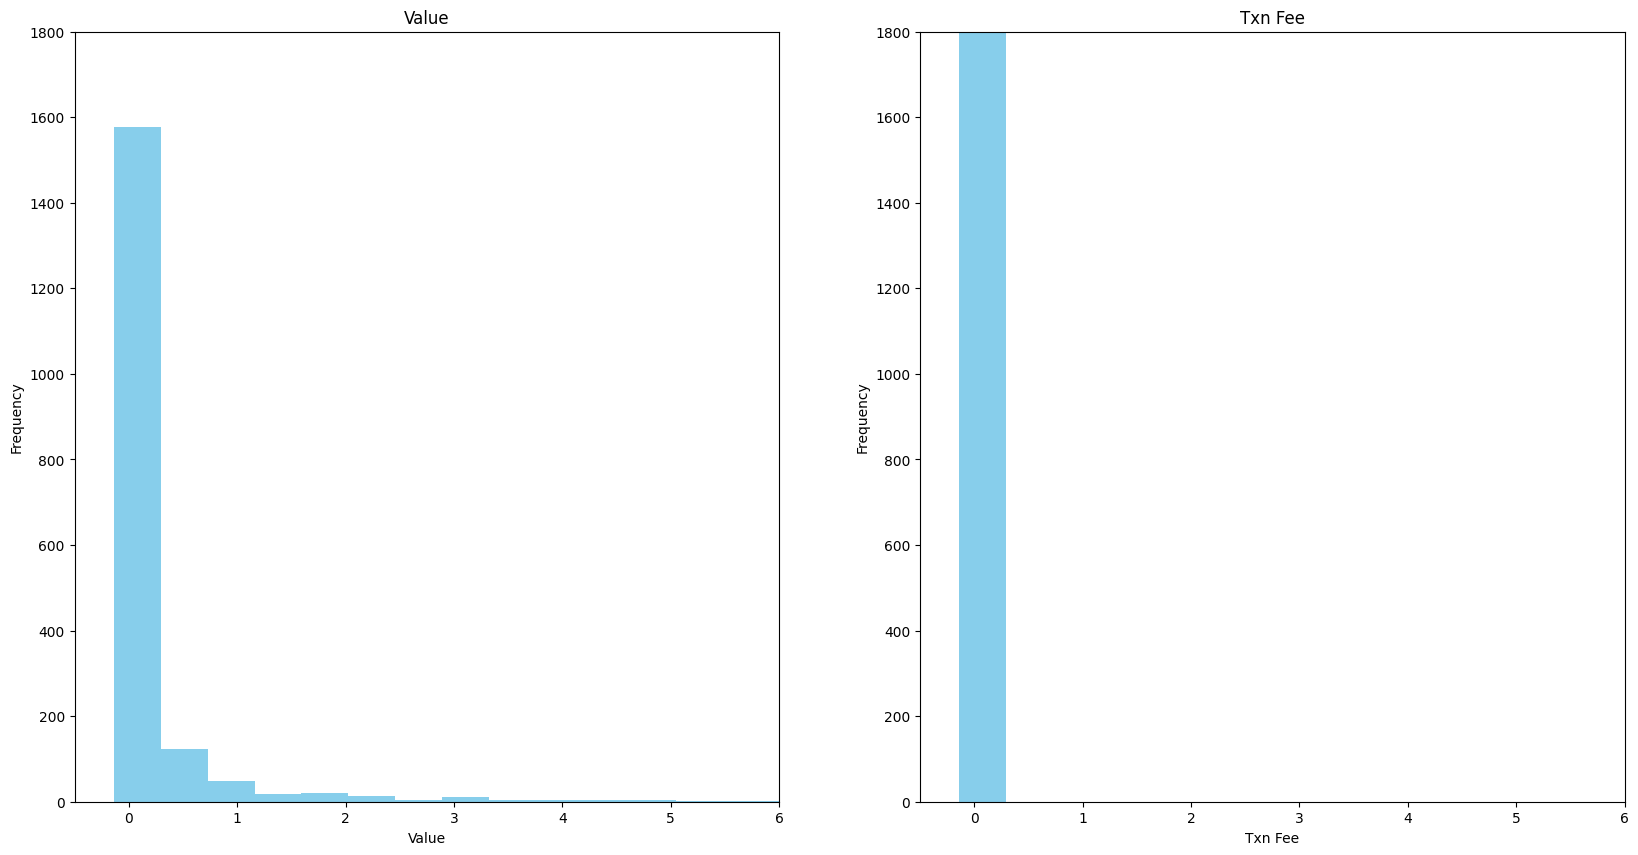

In [59]:
bins = np.histogram_bin_edges(df["Value"], bins="rice") - 1 # bins = int(2 * len(df) ** (1/3))
plot_histograms(df, bins, "skyblue")

Like Sturges' formula, Rice's rule is simple to calculate and is a good choice for small datasets. However, it may not be the best choice for large datasets.


-   **Freedman-Diaconis Rule**: This rule uses the interquartile range (IQR) to find the bin width, and then calculates the number of bins accordingly:

    $$\text{Bin Width} = 2 * \frac{\text{IQR}}{\text{Cube Root of Number of Data Points}}$$
    $$\text{Number of Bins} = \frac{\text{Range of Data}}{\text{Bin Width}}$$


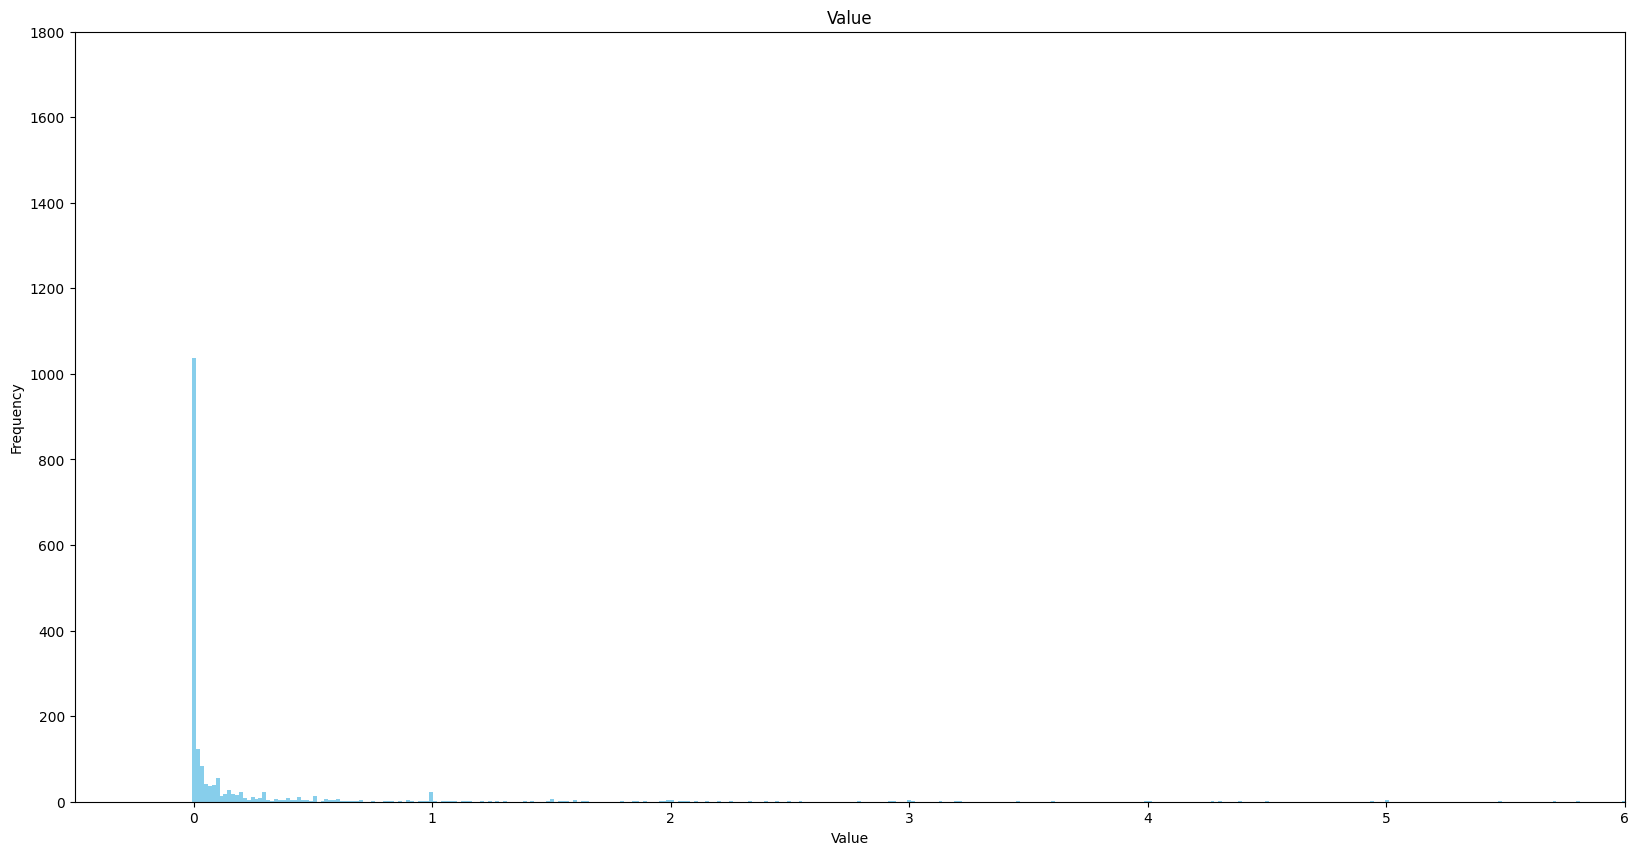

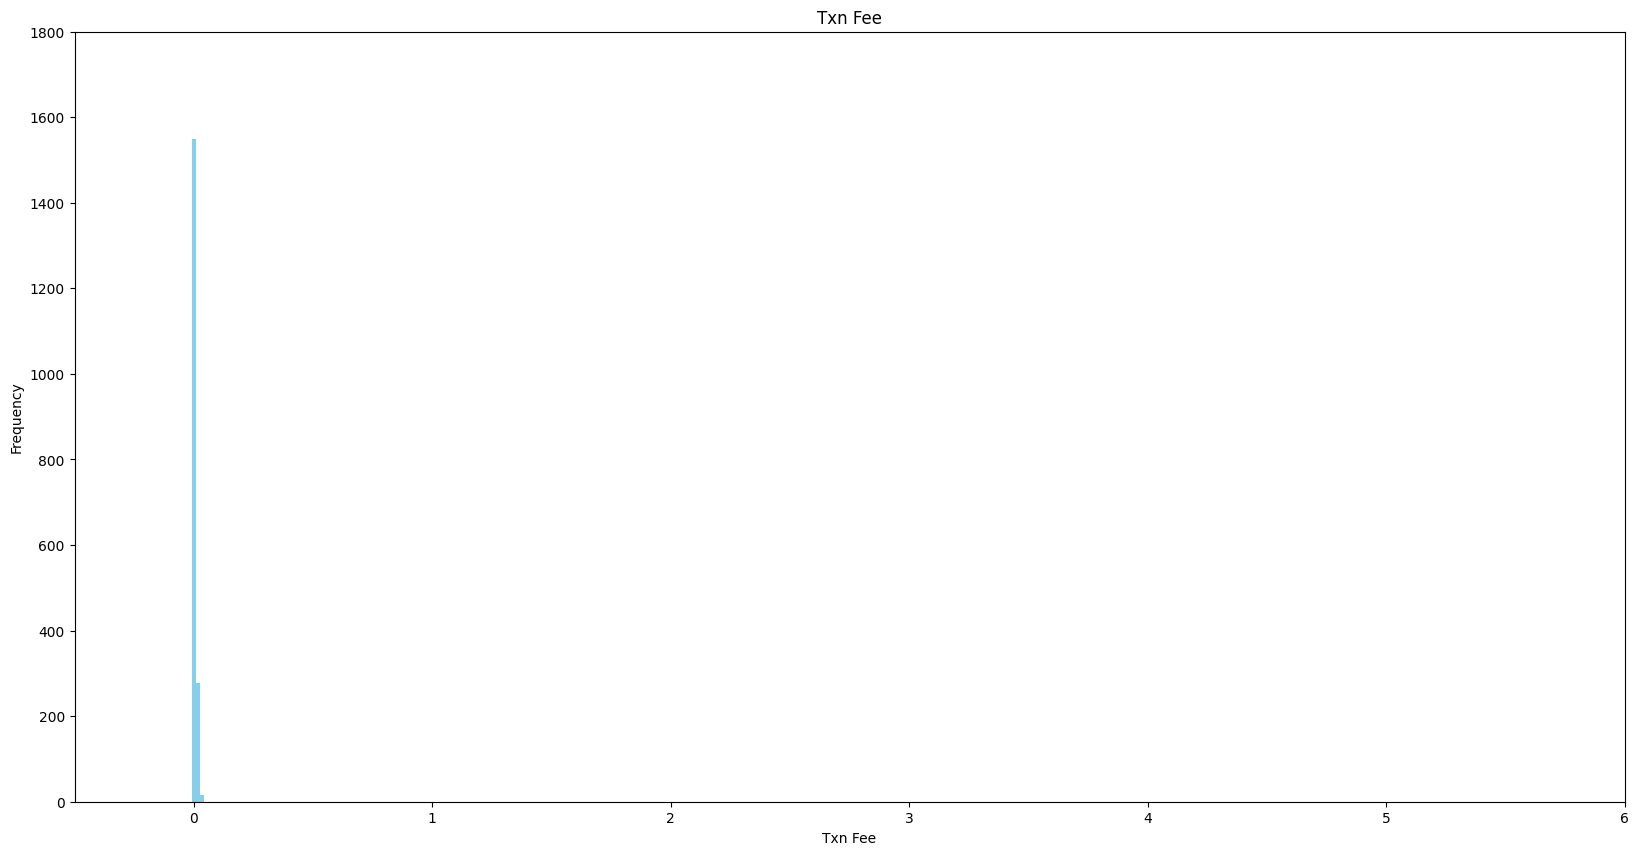

In [60]:
bins = np.histogram_bin_edges(df["Value"], bins="fd") - 1 # bins = int((df["Value"].max() - df["Value"].min()) / (2 * stats.iqr(df["Value"]) / len(df) ** (1/3)))
plot_histograms(df, bins, "skyblue", subplot=False)

This method is robust to changes in the data and is a good choice for large datasets, and in general, it is a good choice for our dataset since the other methods have a lot of zeros.


-   -   A normal distribution plot fitted alongside the histogram to compare the empirical distribution of the data with the theoretical normal distribution.


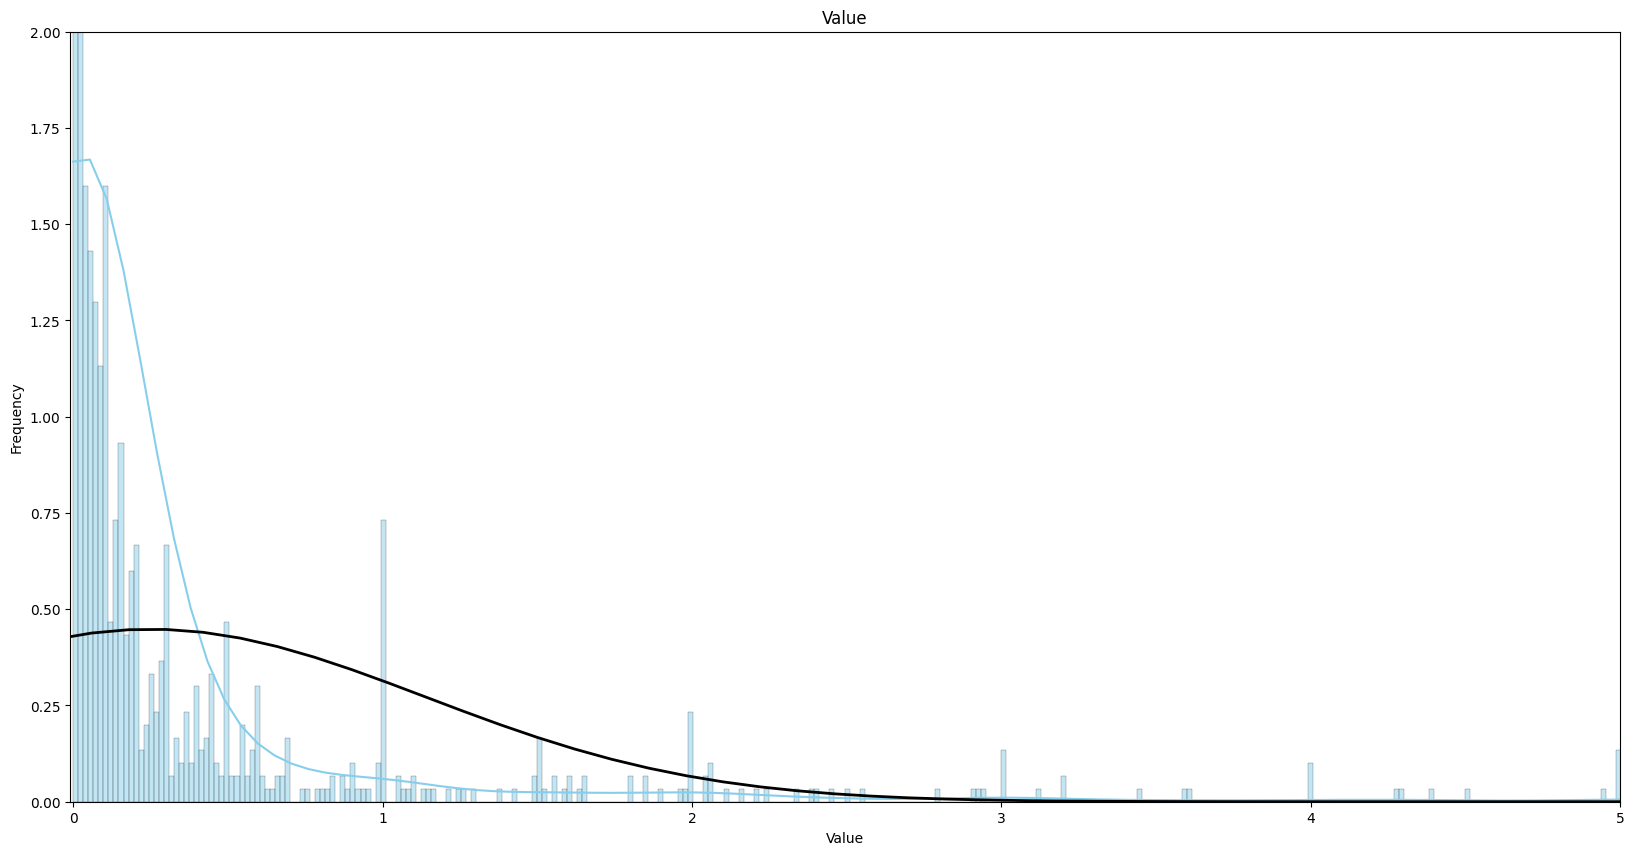

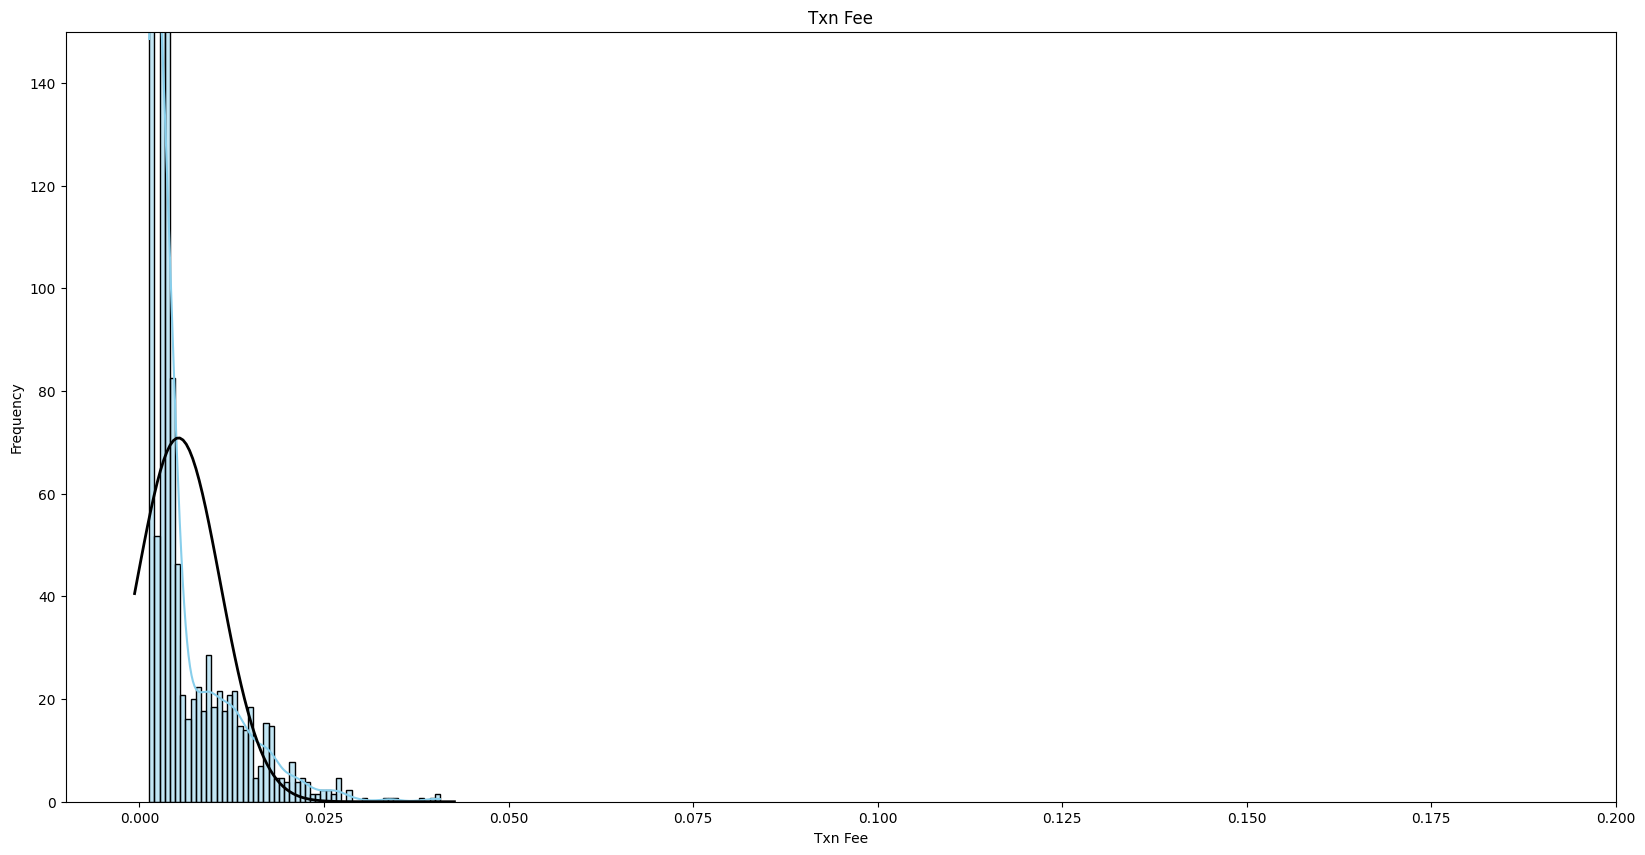

In [10]:
def plot_normal_along_histogram(
    data: pd.Series,
    title: str,
    xlabel: str,
    ylabel: str,
    xlim: tuple[int, int],
    ylim: tuple[int, int],
    color: str,
):
    plt.figure(figsize=(20, 10))

    sns.histplot(data, kde=True, color=color, stat="density")

    mu, std = stats.norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, "k", linewidth=2)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


plot_normal_along_histogram(
    df["Value"], "Value", "Value", "Frequency", (-0.01, 5), (0, 2), "skyblue"
)
plot_normal_along_histogram(
    df["Txn Fee"], "Txn Fee", "Txn Fee", "Frequency", (-0.01, 0.2), (0, 150), "skyblue"
)

The normal distribution plot is not visible in the histogram of the `Value` column because of the maximum height of the histogram. Let's zoom in on the histogram to better visualize the normal distribution plot.


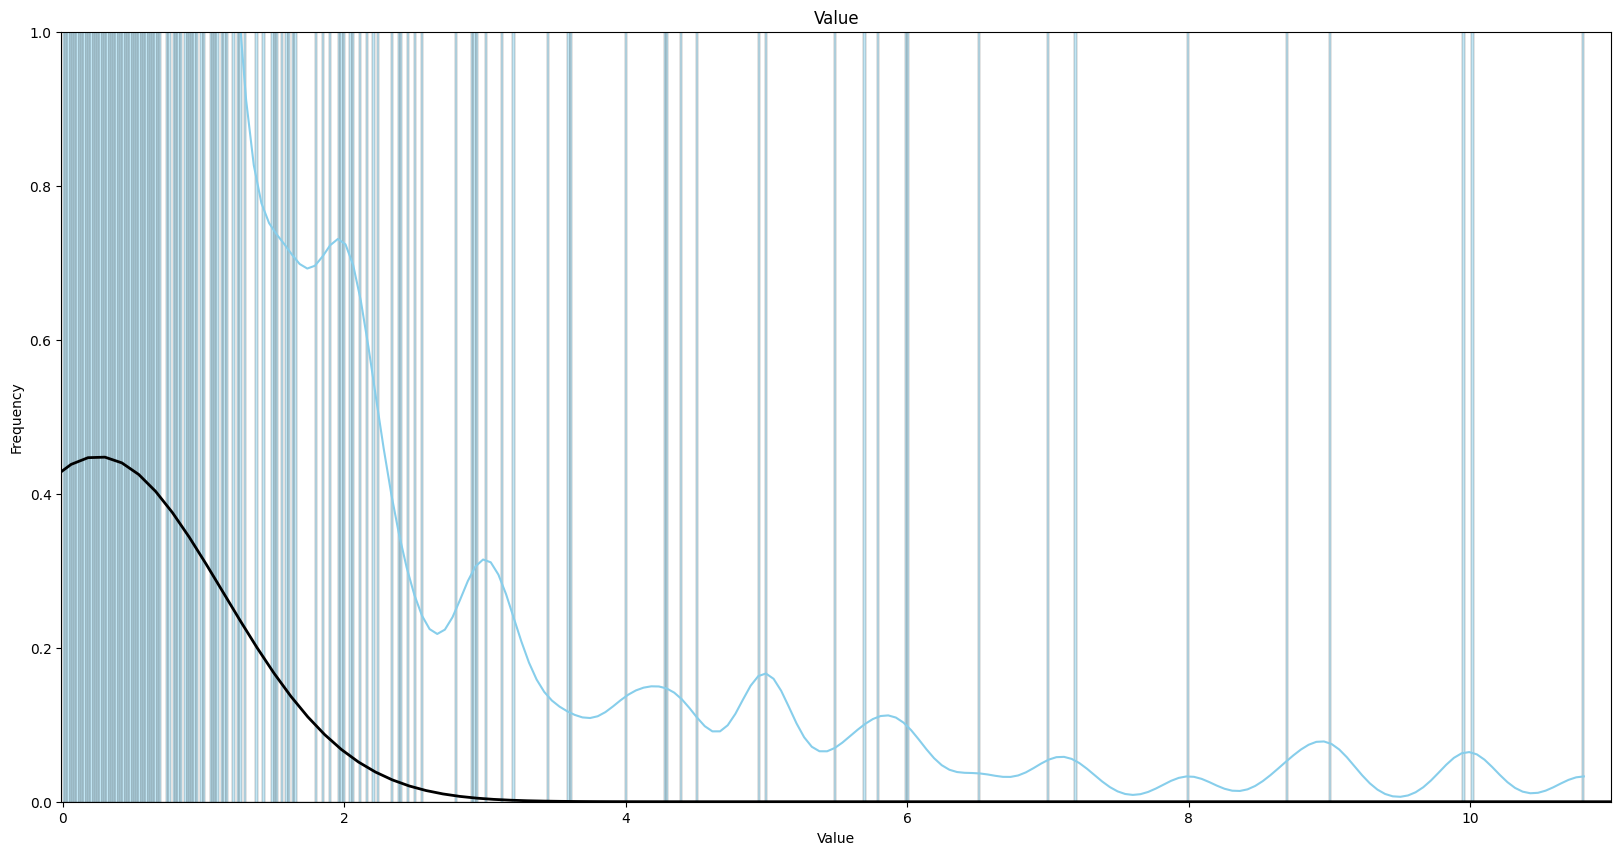

In [111]:
plot_normal_along_histogram(
    df["Value"], "Value", "Value", "Frequency", (-0.01, 11), (0, 1), "skyblue"
)

We can see that the distribution of the `Value` column is not normal, as the empirical distribution does not match the theoretical normal distribution. The distribution is positively skewed, and the normal distribution plot does not fit the histogram well.


-   -   A box plot and a violin plot to identify outliers and provide a comprehensive view of the data's distribution.


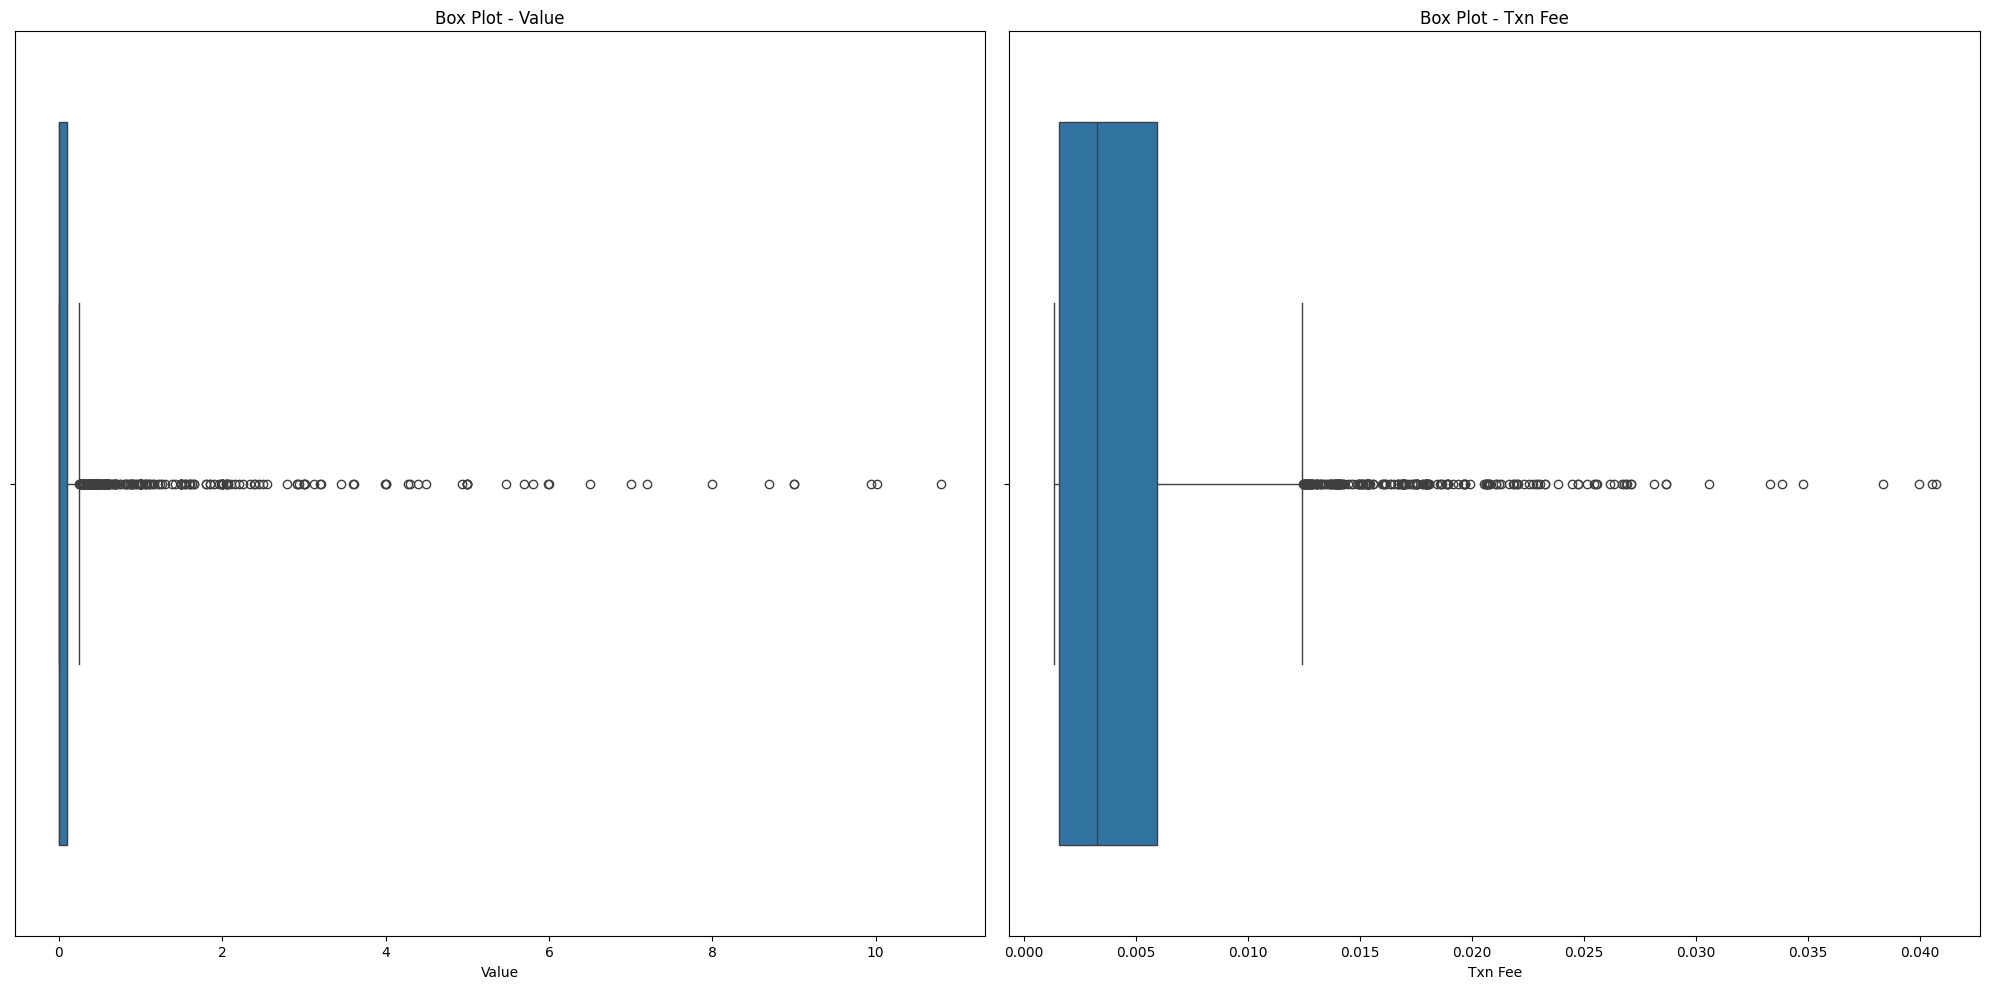

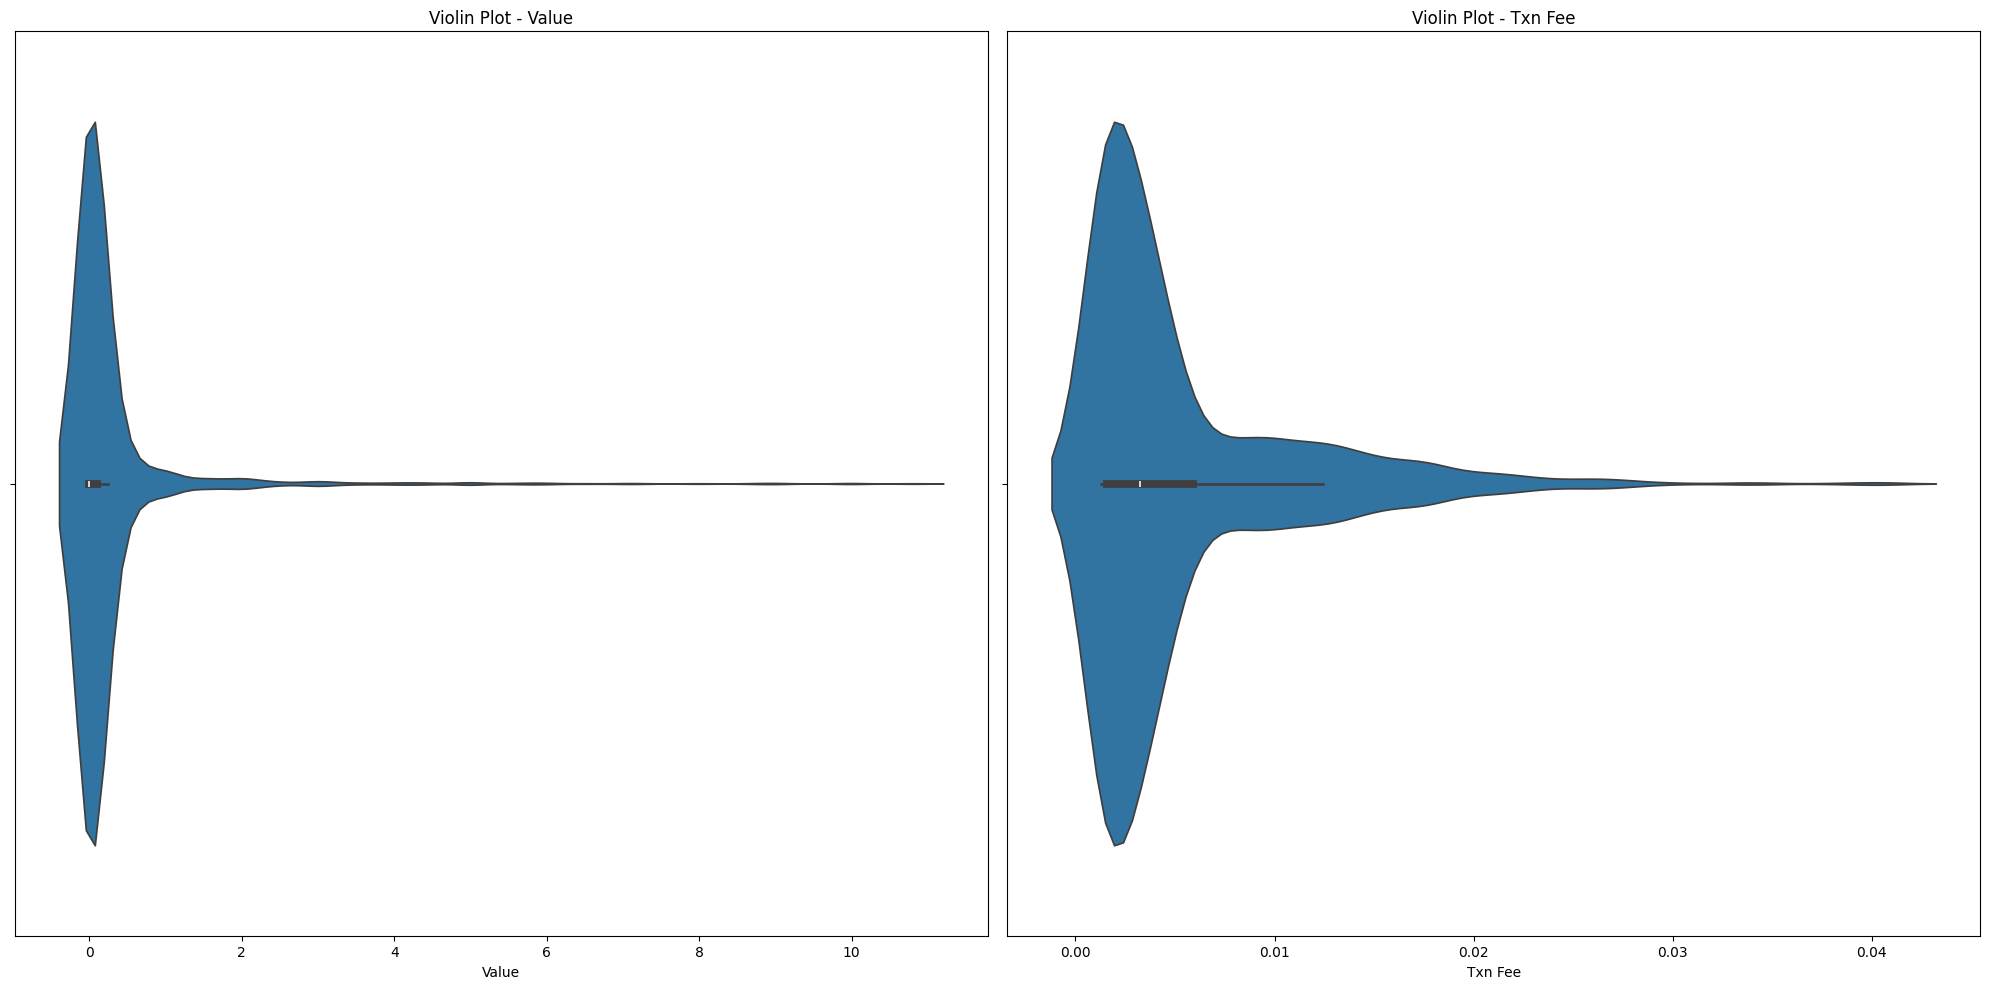

In [112]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="Value")
plt.title("Box Plot - Value")

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x="Txn Fee")
plt.title("Box Plot - Txn Fee")

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.violinplot(data=df, x="Value")
plt.title("Violin Plot - Value")

plt.subplot(1, 2, 2)
sns.violinplot(data=df, x="Txn Fee")
plt.title("Violin Plot - Txn Fee")

plt.tight_layout()
plt.show()


All these plots show that in both `Value` and `Txn Fee` columns, most of the data is concentrated around 0, and there are some outliers with very high values. This is why the data is positively skewed.


## Data Sampling and Analysis

In this section, we will delve into the process of data sampling and perform an initial analysis on the transaction data we have collected. Our objective is to understand the distribution of transaction values by sampling the data and comparing the sample statistics with the population statistics.

### Considerations

-   **Sample Size**: The size of the sample should be large enough to represent the population accurately but not so large that it becomes impractical to analyze.
    -   **Representative of Population**: The sample size needs to be large enough to accurately represent the population. If the sample size is too small, it may not capture the full diversity and variability of the population, leading to bias and inaccurate results. For example, if you’re conducting a survey about people’s opinions on a particular topic, a larger sample size would likely give a more accurate reflection of the overall population’s opinion.
    -   **Practicality of Analysis**: On the other hand, if the sample size is too large, it can become impractical to manage and analyze the data. Larger datasets require more resources for storage, processing, and analysis. They can also make it more difficult to detect meaningful differences or effects, as minor and potentially irrelevant differences can become statistically significant.
-   **Sampling Method**: Choose the appropriate sampling method based on the characteristics of the data and the research question.
    -   **Simple Random Sampling (SRS)**: In this method, each member of the population has an equal chance of being selected. This method is straightforward and easy to implement, but it may not be the most efficient or effective method for all types of data. For example, if the population is large and diverse, simple random sampling may not capture the full range of variability in the population.
    -   **Stratified Sampling**: In this method, the population is divided into subgroups (or strata) based on certain characteristics, and then samples are randomly selected from each subgroup. This method can be more effective for capturing the diversity of the population, especially if there are distinct subgroups with different characteristics.

### Steps

1. **Simple Random Sampling (SRS)**: Create a sample from the dataset using a simple random sampling method. This involves randomly selecting a subset of the data without regard to any specific characteristics of the data.


In [113]:
df = pd.read_csv(TRANSACTIONS_CLEANED_CSV)

In [114]:
def simple_random_sampling(df: pd.DataFrame, sample_proportion: float, random_seed: int) -> pd.DataFrame:
    return df.sample(frac=sample_proportion, random_state=random_seed, replace=False)

srs_df = simple_random_sampling(df, SAMPLE_PROPORTION, RANDOM_SEED)

2. **Stratified Sampling**: Create another sample from the dataset using a stratified sampling method. This involves dividing the data into strata based on a specific characteristic (e.g., transaction value) and then randomly selecting samples from each stratum. We'll stratify the data based on the `Method` and `Block` columns and compare the sample statistics with the population statistics to find out which method is more effective in capturing the diversity of the population.


In [118]:
def stratified_sampling(
    df: pd.DataFrame,
    characteristic: str = "Block",
    sample_proportion: float = 0.1,
    random_seed: int = 42,
) -> pd.DataFrame:
    grouped_df = df.groupby(characteristic)
    return grouped_df.apply(
        lambda x: x.sample(
            frac=sample_proportion, random_state=random_seed, replace=False
        ),
        include_groups=False,
    )


stratified_block_df = stratified_sampling(df, "Block", SAMPLE_PROPORTION, RANDOM_SEED)
stratified_method_df = stratified_sampling(df, "Method", SAMPLE_PROPORTION, RANDOM_SEED)

3. **Statistical Analysis**: Calculate the mean and standard deviation of the samples and the population. Compare these statistics to understand the distribution of transaction values.


In [121]:
sample_srs_mean = srs_df["Value"].mean()
sample_srs_std = srs_df["Value"].std()

sample_stratified_block_mean = stratified_block_df["Value"].mean()
sample_stratified_block_std = stratified_block_df["Value"].std()

sample_stratified_method_mean = stratified_method_df["Value"].mean()
sample_stratified_method_std = stratified_method_df["Value"].std()

population_mean = df["Value"].mean()
population_std = df["Value"].std()

print("Sample SRS Mean:", sample_srs_mean)
print("Sample SRS Standard Deviation:", sample_srs_std)
print("-" * 70)
print("Sample Stratified (Block) Mean:", sample_stratified_block_mean)
print("Sample Stratified (Block) Standard Deviation:", sample_stratified_block_std)
print("-" * 70)
print("Sample Stratified (Method) Mean:", sample_stratified_method_mean)
print("Sample Stratified (Method) Standard Deviation:", sample_stratified_method_std)
print("-" * 70)
print("Population Mean:", population_mean)
print("Population Standard Deviation:", population_std)


Sample SRS Mean: 0.2120013060217391
Sample SRS Standard Deviation: 0.6330496662444084
----------------------------------------------------------------------
Sample Stratified (Block) Mean: 0.33299872733513514
Sample Stratified (Block) Standard Deviation: 1.193131785284552
----------------------------------------------------------------------
Sample Stratified (Method) Mean: 0.29156489260215057
Sample Stratified (Method) Standard Deviation: 1.0381805252717649
----------------------------------------------------------------------
Population Mean: 0.24994040214650026
Population Standard Deviation: 0.8903523324988084


-   **Mean**: The mean of the stratified by `Method` sample (0.291) is closer to the population mean (0.250) than the mean of the stratified by `Block` sample (0.333). This is because stratifying by `Method` captures the diversity of the population more effectively, as it accounts for the different transaction methods, which have varying transaction values. Stratifying by `Block` does not capture the diversity as effectively, as it groups transactions based on the block number, which may not be directly related to the transaction values. Also, the mean of the stratified by `Method` is almost as close to the population mean as the mean of the SRS sample (0.212), which indicates that both methods are effective in capturing the diversity of the population.

-   **Standard Deviation**: The standard deviation of the stratified by `Block` sample (1.193) is larger than the standard deviation of the SRS sample (0.633), stratified by `Method` (1.038) and the population (0.890). The standard derivation of the stratified by `Method` is closer to the population standard deviation than the other samples. This indicates that stratifying by `Method` captures the diversity of the population more effectively, as it accounts for the different transaction methods, which have varying transaction values. However, it is still larger than the population standard deviation. A larger standard deviation indicates more variability in the data. This could be due to the fact that stratified sampling ensures representation from all strata of the population, which might have increased the overall variability of the sample.


4. **Visualization**: Plot the distribution of transaction values and fees for both the samples and the population to visually compare their distributions.


In [122]:
def count_values_in_column(df: pd.DataFrame, column_name: str) -> pd.Series:
    return df[column_name].value_counts()


def plot_distributions_along_sample(
    df: pd.DataFrame, srs_df: pd.DataFrame, column: str, x_label: str, title: str
):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df[column], bins=10, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title("Population Distribution")
    plt.xlabel(x_label)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(srs_df[column], bins=10, color="salmon", edgecolor="black", alpha=0.7)
    plt.title("Sample Distribution" + title)
    plt.xlabel(x_label)
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

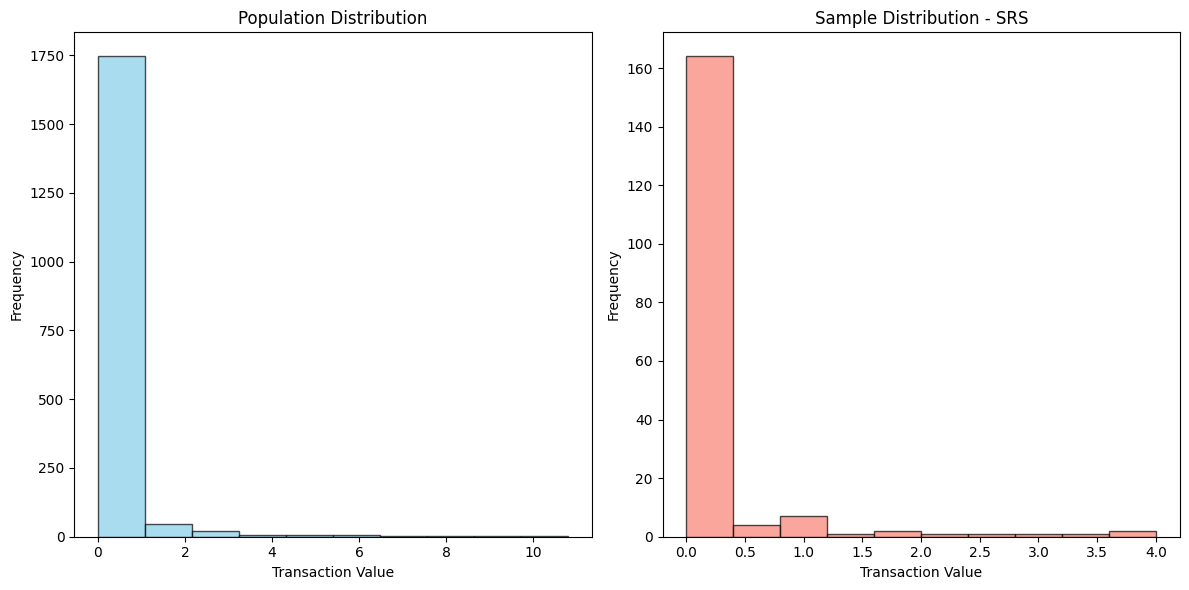

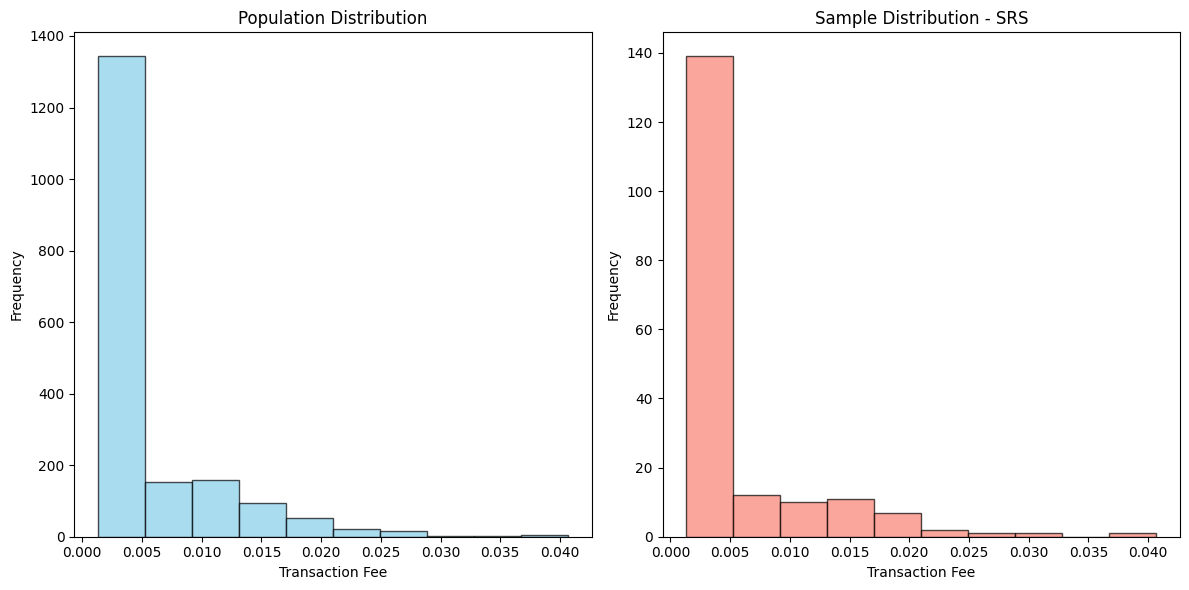

In [123]:
plot_distributions_along_sample(df, srs_df, "Value", "Transaction Value", " - SRS")
plot_distributions_along_sample(df, srs_df, "Txn Fee", "Transaction Fee", " - SRS")

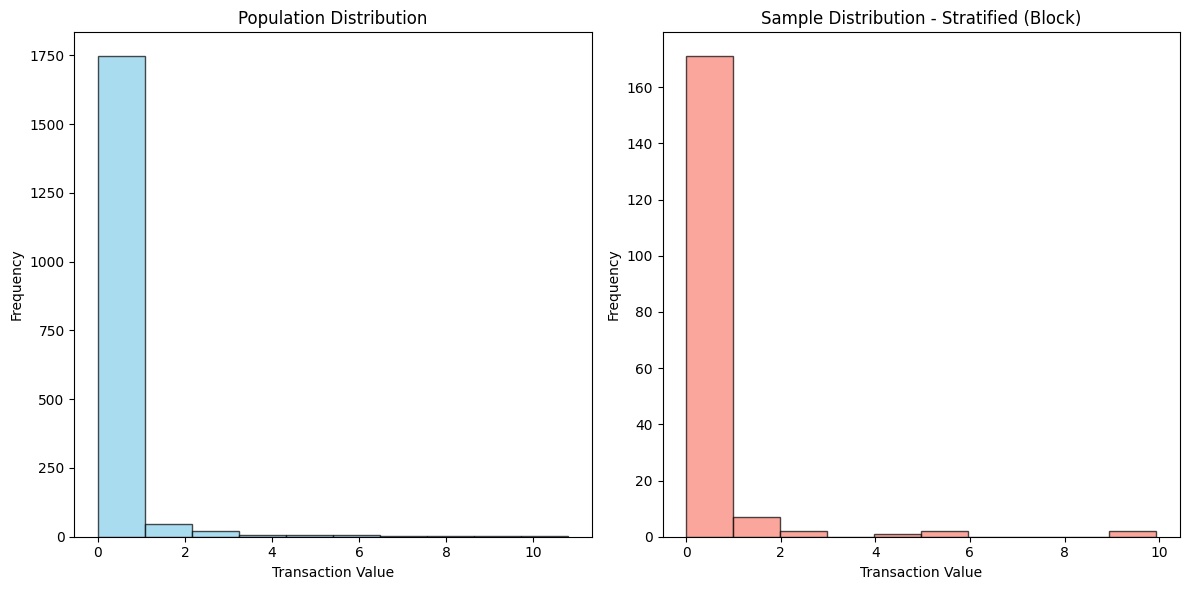

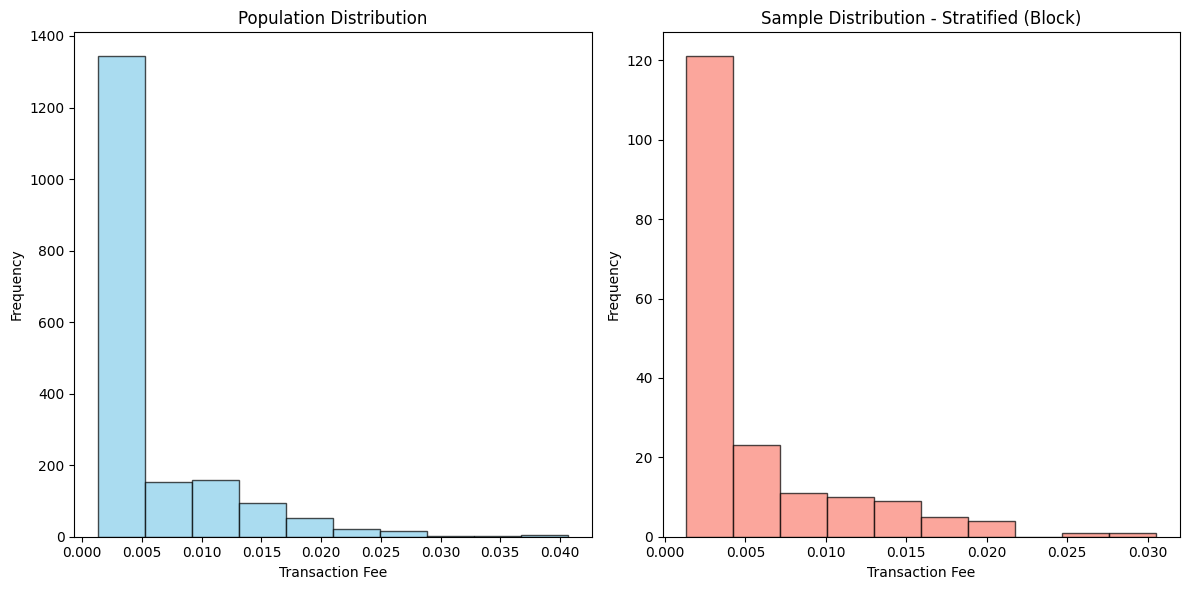

In [124]:
plot_distributions_along_sample(df, stratified_block_df, "Value", "Transaction Value", " - Stratified (Block)")
plot_distributions_along_sample(df, stratified_block_df, "Txn Fee", "Transaction Fee", " - Stratified (Block)")

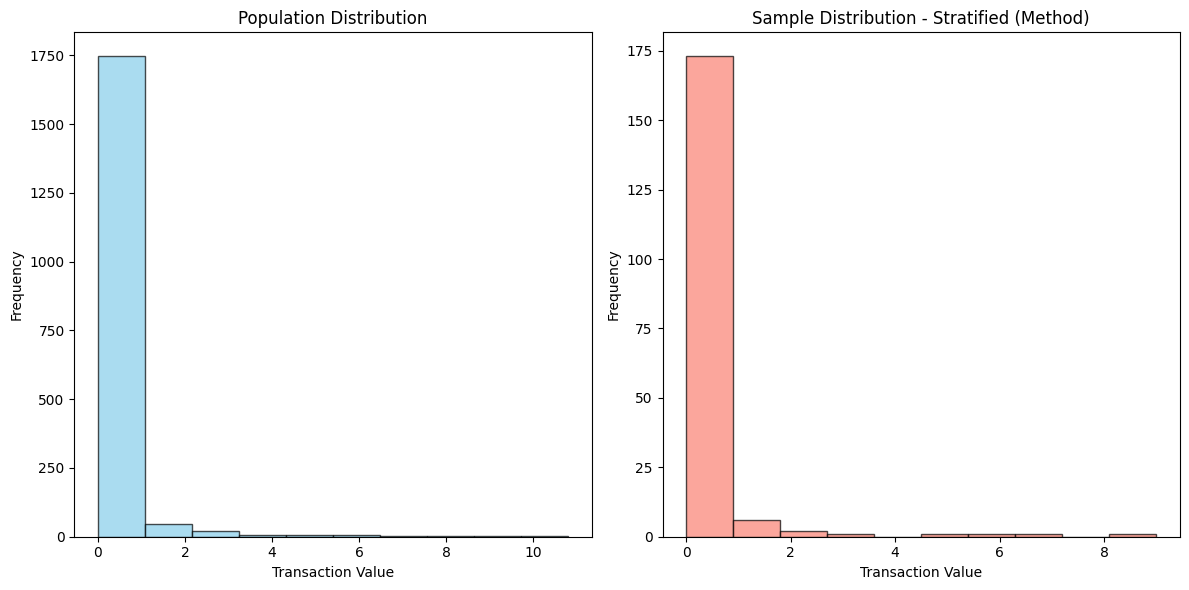

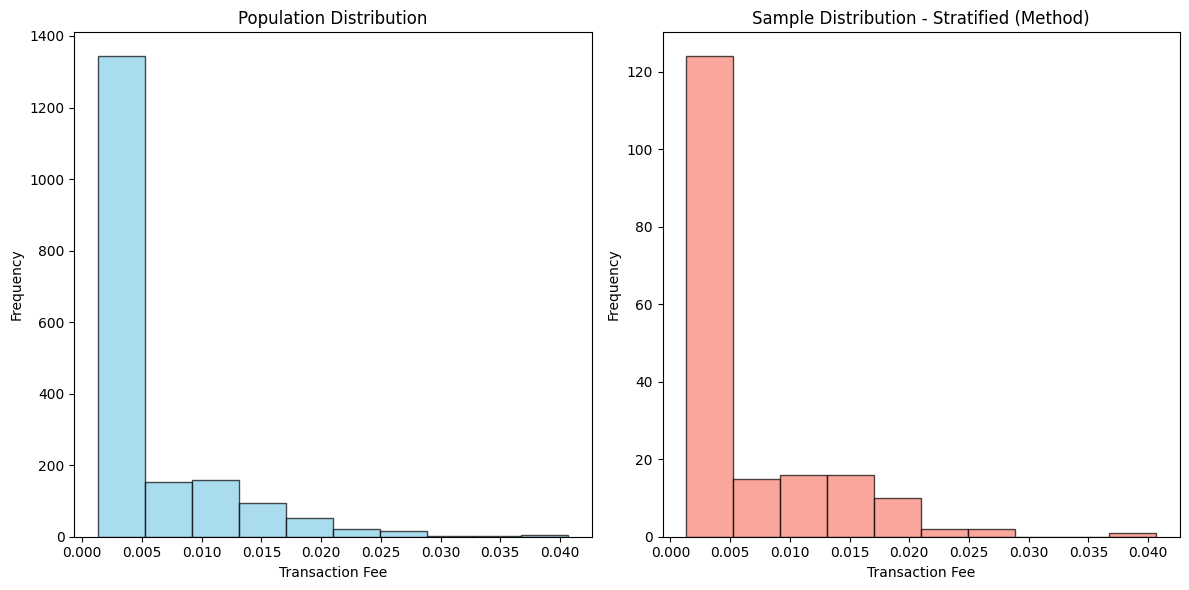

In [125]:
plot_distributions_along_sample(df, stratified_method_df, "Value", "Transaction Value", " - Stratified (Method)")
plot_distributions_along_sample(df, stratified_method_df, "Txn Fee", "Transaction Fee", " - Stratified (Method)")

As it is visible in the plots, the stratified by `Method` sample has a distribution that is closer to the population distribution than the other samples. This further supports the conclusion that stratifying by `Method` is more effective in capturing the diversity of the population.

The next effective method is the SRS method, and the least effective one is stratifying by `Block`.


## Questions

1. **What are some potential limitations when using web scraping for data collection? Specifically, what problems did you face while fetching data from Etherscan? What problems can these limitations cause in your analysis?**

    - **Rate Limiting and IP Blocking**: One common issue is rate limiting or getting banned by the website. Websites often have measures in place to prevent automated scraping, such as limiting the number of requests that can be made from a single IP address in a certain timeframe. If these limits are exceeded, our IP address could have be temporarily or permanently blocked.

    - **Duplication of Entries**: When we are scraping data in real-time from a website where new data is constantly being added, we may encounter the issue of duplicate entries. This happens when new data is added to the site while we are in the process of scraping, causing some data to be scraped more than once.

    - **Dynamic Content**: Many websites use JavaScript to load content dynamically. Traditional scraping tools, which simply download the HTML of a page, can't interact with or download this dynamic content. In this project the problem we faced was that for `Methods` which has long name, the full name is not accessible through the HTML. We couldn't do so much about this since even using JavaScript it wasn't easy to extract data.

    These limitations can impact our data analysis in several ways:

    - **Incomplete Data**: If our scraper is blocked or fails to interact with dynamic content, we may end up with incomplete data, which can lead to inaccurate analysis.
    - **Duplicate Entries**: Duplicate entries can skew our data and lead to incorrect conclusions.

2. **What can make your analysis untrustworthy? What are your solutions?**

    - **Data Quality**: If the data that we collected from the website is incomplete or inaccurate, it could lead to misleading results.
    - **Temporal Changes**: Cryptocurrency transactions happen around the clock and the market can be quite volatile. If there’s a significant time gap between when the data is collected and when the analysis is performed, the results might not accurately represent the current state of the market.
    - **Sampling Bias**: If the data collected isn’t representative of the overall population or the sampling method we used is biased, the results might not be trustworthy.

    Solutions:

    - **Data Validation**: We can validate the data by cross-referencing it with other sources or performing sanity checks to ensure its accuracy.
    - **Repeat Analysis**: If the data is time-sensitive, we can repeat the analysis with updated data to ensure the results are still valid.
    - **Random Sampling**: To avoid sampling bias, we can use random sampling methods to ensure that the sample is representative of the population.

3. **How did the visualization help you in understanding the data? What could you interpret from the plots?**

    - **Histograms**: Histograms provide a visual representation of the distribution of the data. They help us understand the frequency of different transaction values and fees and identify any patterns or outliers in the data.
    - **Normal Distribution Plots**: These plots help us compare the empirical distribution of the data with the theoretical normal distribution. If the data closely follows a normal distribution, it can help us make certain assumptions and predictions about the data, In our case the empirical distribution does not match the theoretical normal distribution, and the distribution is positively skewed.
    - **Box Plots and Violin Plots**: These plots provide a comprehensive view of the data's distribution, including the presence of outliers and the spread of the data. They helped us identify any extreme values and understand the variability of the data.
    - **Sampling Comparison**: By visualizing the distributions of the samples and the population, we can compare their characteristics and identify any differences or similarities. This helped us assess the representativeness of the samples and understand how they compare to the overall population.

4. **How do the two sampling methods differ in their output? Compare these and explain which one is a better fit to the population.**
    - **Simple Random Sampling (SRS)**: In SRS, each member of the population has an equal chance of being selected. This method is straightforward and easy to implement, but it may not capture the full diversity and variability of the population.
    - **Stratified Sampling**: In stratified sampling, the population is divided into subgroups based on certain characteristics, and then samples are randomly selected from each subgroup. This method can be more effective for capturing the diversity of the population, especially if there are distinct subgroups with different characteristics.
      The most important thing in stratified sampling is to choose the right strata. In our case, we chose `Method` and `Block` as strata. The `Method` strata is more effective in capturing the diversity of the population, as it accounts for the different transaction methods, which have varying transaction values. Stratifying by `Block` does not capture the diversity as effectively, as it groups transactions based on the block number, which may not be directly related to the transaction values. In many cases, stratified sampling is more effective in capturing the diversity of the population than SRS, especially if there are distinct subgroups with different characteristics.


## Resources

-   [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
-   [Selenium Documentation](https://selenium-python.readthedocs.io/)
-   [Pandas Documentation](https://pandas.pydata.org/docs/)
-   [Ethereum](https://ethereum.org/en/)
-   [Z Score](https://www.statisticshowto.com/probability-and-statistics/z-score/)
-   [Sampling Methods](https://www.scribbr.com/methodology/sampling-methods/)
-   [Sampling Techniques](https://www.scribbr.com/methodology/sampling-techniques/)
-   [Bin Size Selection](https://www.statisticshowto.com/choose-bin-sizes-statistics/)
